**CSC466 Final Project Report**

someone who is already
familiar with data mining, but not your topic could be able to
read your project report and understand: what your problem is,
where the data is from, how it was collected, what data mining
techniques you tried, what worked and what didn't work, what
conclusions you were able to make, etc.

**Facial Recognition Library Model**

**DeepFace Library Model**

This model was the one that performed the worst. Our theory is that it was not suited to the style of photo that was present in the dataset, which were frequently off-center, non-forward facing, or had multiple people in the frame. Additionally, for some photos the model couldn't even recognize that there was a face present in the image at all. The model we used was created in 2015 and its poor accuracy could be attributed to its age.

For this model, we used the `pairs.csv` file, which is a list of pairs of photos for people with more than one photo in the dataset. We read in the data and removed any rows containing two different people. Then, we fed each pair to the model and asked it to verify whether the two photos were of the same person.  

If it wrongly declared two photos as not of the same person, the person's name was added to the list of misidentified people. This would allow us to go back through the people later on to see if there were any trends within the misidentified people.


**Results matrix:**

`[2285, 3415]` [correct, incorrect]

The file of people that were misidentified can be found in `deepFaceMisidentified.csv`. Some people who had more than 2 photos appeared in the `pairs.csv` file more than once, so they were checked more times. If they were misidentified more than once, they will appear in the .csv file several times.
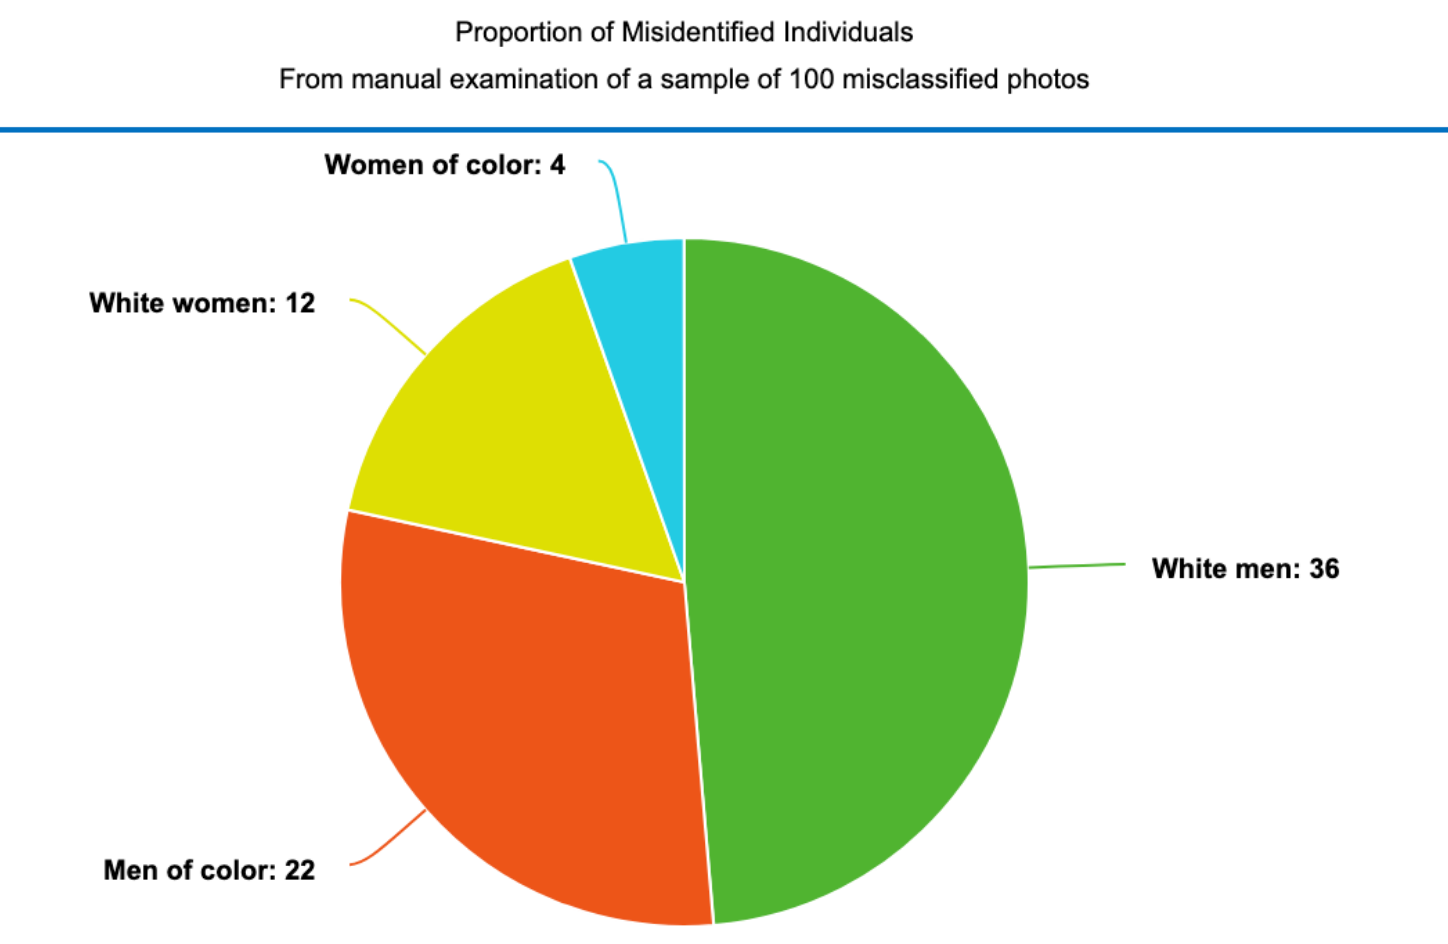

![image.png](attachment:image.png)

In [ ]:
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt


def verify(pairSet):
    # Initialize a dictionary to keep track of model scores
    model = "VGG-Face"      # The DeepFace library has a variety of models. We chose to use VGG-Face
    model_score = [0, 0]
    misclassified_faces = []

    # Check each pair against each model
    for pair in pairSet:
        # Establish the folder and two images to look at
        path = "archive/lfw-deepfunneled/lfw-deepfunneled/" + pair[0] + "/"
        img1_path = path + pair[1] + ".jpg"
        img2_path = path + pair[2] + ".jpg"
        try:
            res = DeepFace.verify(img1_path, img2_path, model_name = model)
            if res['verified']:
                model_score[0] += 1
            else:
                model_score[1] += 1
                misclassified_faces.append(pair[0])
        # Some faces cannot be identified as a face by the model
        except Exception:
            model_score[1] += 1
            misclassified_faces.append(pair[0])

    # Display the number of correctly and incorrectly classified faces, as well as who was misclassified
    print(model_score)
    print(misclassified_faces)


def getPeople():
    # Open and read the file
    pairs = open("archive/pairs.csv", "r")
    pairs = pairs.read().splitlines()

    # Extract the pairs and transform to file stubs
    pairs = [pair.split(",")[:3] for pair in pairs][1:5701]
    pairs = [[pair[0], pair[0] + "_" + pair[1].zfill(4), pair[0] + "_" + pair[2].zfill(4)] for pair in pairs]

    return pairs


verify(getPeople())

**FaceNet Library Model**

This model performed the best to identify the same person given multiple pictures of themselves. We think it is because of the MTCNN (the Multi-task cascaded Convolutional Networks) which is a tool that was used for face detection and alignment, ensuring that the faces are correctly cropped and aligned prior to embedding calculation. The other models did not have that thus it could have led to inaccurate fitting/recognition of images that would've been recognized if they were pre-processed with the MTCNN.

For this model, we used the training folder from the original dataset that contained a folder with thousands of other folders each one with one or more photos of the same person. We used an algorithm shown below to create pairs of images from folders with greater than 1 and less than 12 photos of the same person (for time's sake). We fed the model each pair of 2 photos and the model would label if they were recognized as the same person or not.

If it wrongly declared two photos as not of the same person, the person's name was added to the list of misidentified people. This would allow us to go back through the people later on to see if there were any trends within the misidentified people.

Our results matrix was:  [5204, 496] [correct, incorrect]

After running, the model prints the location of the misidentified people and we manually looked up each name and noted which demographic they were a part of. This resulted in the following pie chart.


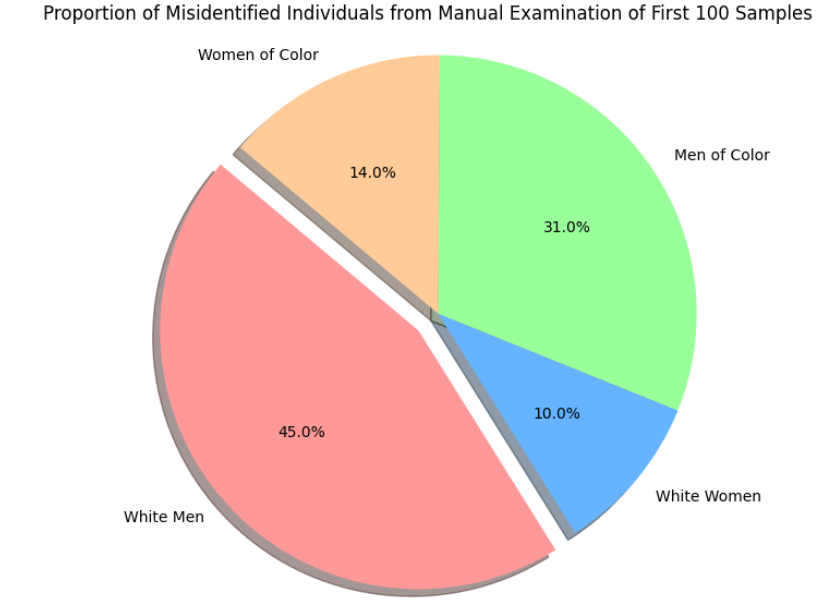

In [ ]:
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import os
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("verification.log"),
        logging.StreamHandler()
    ]
)

# Function to preprocess image and return the embeddings
def get_embedding(model, mtcnn, img_path):
    logging.info(f"Processing image: {img_path}")
    img = Image.open(img_path)
    img_cropped = mtcnn(img)
    if img_cropped is None:
        raise ValueError("Face not detected")
    with torch.no_grad():
        embedding = model(img_cropped.unsqueeze(0))
    return embedding

# Function to generate pairs of images from the training folder
def generate_pairs(training_dir):
    logging.info("Generating pairs from training directory")
    pairs = []
    for person_dir in os.listdir(training_dir):
        person_path = os.path.join(training_dir, person_dir)
        if os.path.isdir(person_path):
            images = [os.path.join(person_path, img) for img in os.listdir(person_path) if img.endswith('.jpg')]
            if 2 <= len(images) <= 11:
                for i in range(len(images)):
                    for j in range(i + 1, len(images)):
                        pairs.append((images[i], images[j]))
    logging.info(f"Generated {len(pairs)} pairs")
    return pairs

# Function to verify if two images are of the same person
def verify(pairs):
    logging.info("Starting verification process")
    model_score = [0, 0]
    misclassified_faces = []

    # Load the FaceNet model
    model = InceptionResnetV1(pretrained='vggface2').eval()
    mtcnn = MTCNN(image_size=160, margin=0)

    def process_pair(img1_path, img2_path):
        try:
            embedding1 = get_embedding(model, mtcnn, img1_path)
            embedding2 = get_embedding(model, mtcnn, img2_path)
            distance = torch.dist(embedding1, embedding2).item()
            threshold = 1.0
            if distance < threshold:
                logging.info(f"Match: {img1_path} and {img2_path}")
                return (True, img1_path, img2_path)
            else:
                logging.info(f"No Match: {img1_path} and {img2_path}")
                return (False, img1_path, img2_path)
        except Exception as e:
            logging.error(f"Error processing pair ({img1_path}, {img2_path}): {e}")
            return (False, img1_path, img2_path)

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(process_pair, img1, img2) for img1, img2 in pairs]
        for future in as_completed(futures):
            result, img1, img2 = future.result()
            if result:
                model_score[0] += 1
            else:
                model_score[1] += 1
                misclassified_faces.append((img1, img2))

    logging.info(f"Model Score: {model_score}")
    logging.info(f"Misclassified Faces: {misclassified_faces}")

# Set the directories relative to the project directory
training_dir = os.path.join(os.getcwd(), 'training')

logging.info("Script started")
pairs = generate_pairs(training_dir)
verify(pairs)
logging.info("Script finished")